In [320]:
using UMAP: umap
using MLDatasets
using VegaLite
using DataFrames
using OptimalTransport
using Tulip
using Distances
using CUDA

In [323]:
x = MNIST.traintensor(Float64)
mnist_x = reshape(x, 28*28, :);
mnist_y = MNIST.trainlabels(1:size(mnist_x, 2));

normalize_mnist(x) = mnist_x[:,x] / sum(mnist_x[:,x])
norm_mnist_x = normalize_mnist.(1:length(mnist_x[1,:]));
X_norm = hcat(norm_mnist_x...);

In [3]:
res_jl = umap(mnist_x; n_neighbors=10, min_dist=0.001, n_epochs=200)

2×60000 Matrix{Float64}:
 -2.4832   -13.0138    2.94824   7.3455   …  -2.51287  -8.06639   3.79361
  1.83972    0.423095  9.20645  -6.93097      1.84111  -0.85726  -1.41936

In [4]:
df = DataFrame(
    x1    = res_jl'[:,1],
    x2    = res_jl'[:,2],
    label = mnist_y);

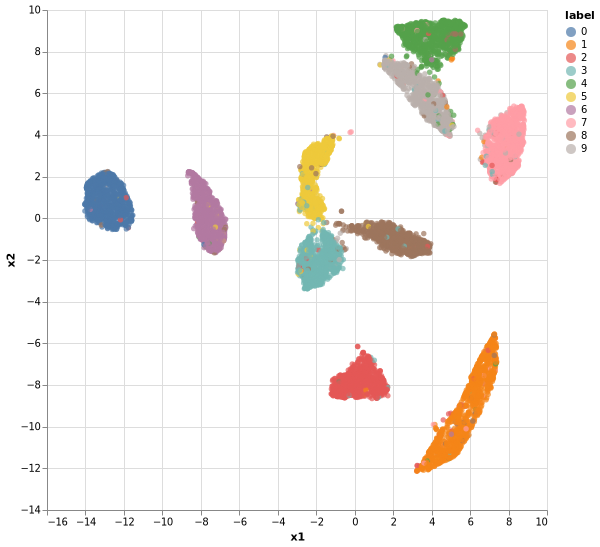

In [8]:
@vlplot(data=df[1:10000,:],:circle,x={:x1},y={:x2},color={:label, type="nominal"},height=500,width=500)

In [317]:
N = 10
n = 28
distm = collect(Iterators.product(1:n,1:n));
μ = reshape(distm,n*n);
ν = reshape(distm,n*n);
D = zeros(N,N)
for i in 1:N
    for j in i+1:N
        u = norm_mnist_x[i]
        v = norm_mnist_x[j]
        C = float.(Distances.pairwise(Distances.SqEuclidean(), μ[u.>0], ν[v.>0]))
        u = u[u.>0]
        v = v[v.>0]
#         D[i,j] = emd2(u,v,C,Tulip.Optimizer())
        D[i,j] = sinkhorn2(u,v,C,10)
        D[j,i] = D[i,j]
    end
end
